# k-means
### Modelo 02
- CountVectorizer
- Base B


#### Imports necessarios para funcionamento da aplicacao

In [1]:
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score
from nltk import word_tokenize
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

#### Leitura do arquivo de dados

In [2]:
df = pd.read_csv('../../base_b.csv')

df.head()

,nome,categoria
0,BRAHMA,BRAHMA
1,BRAHMA 550ML,BRAHMA
2,BRAHMA CERV 350ML LT,BRAHMA
3,BRAHMA CERVEJA 350ML,BRAHMA
4,BRAHMA CERVEJA 350ML LT,BRAHMA


#### Efetua o tratamento dos dados

In [3]:
le = LabelEncoder()

df.categoria = le.fit_transform(df.categoria)

df.head()

,nome,categoria
0,BRAHMA,0
1,BRAHMA 550ML,0
2,BRAHMA CERV 350ML LT,0
3,BRAHMA CERVEJA 350ML,0
4,BRAHMA CERVEJA 350ML LT,0


#### Função de tokenização

In [4]:
stemmer = RSLPStemmer()

def token(text):
    text = re.sub('[0-9]|,|\.|/|$|\(|\)|-|\+|:|•', ' ', text)
    txt = word_tokenize(text.lower())
    return [stemmer.stem(word) for word in txt]

#### Lista de Stop Words

In [5]:
stopwords_arquivo = pd.read_csv('../../stopwords.csv')

lista_stop_words = [ token(word)[0] for word in stopwords_arquivo.stopwords.values ]

#### Separa base de treino e teste

In [6]:
X_train,X_test,y_train,y_test = train_test_split(
    df.nome,
    df.categoria,
    test_size = 0.3,
    random_state = 42
)

#### Define CountVectorizer

In [7]:
count_vectorizer = CountVectorizer(
    tokenizer=token,
    ngram_range=(1,1),
    stop_words=lista_stop_words
)

#### Cria vocabulário

In [8]:
X_train = count_vectorizer.fit_transform(X_train.values)

## Etapa de treinamento
#### Cria um classificador k-means

In [9]:
kmeans = KMeans(
    n_clusters = 15,
    random_state=24
)

#### Treina o classificador

In [10]:
kmeans.fit(X_train.toarray(), y_train)

KMeans(n_clusters=15, random_state=24)

## Etapa de Teste

#### Efetua a predição

In [11]:
Y_Pred = kmeans.predict(count_vectorizer.transform(X_test).toarray())

#### Calcula a acurácia do classificador

In [12]:
print('acuracia: {:.1f}'.format(accuracy_score(y_test, Y_Pred) * 100))
print('precisao: {:.1f}'.format(precision_score(y_test, Y_Pred, average="weighted") * 100))

acuracia: 7.2
precisao: 7.2


#### Tabela com os itens classificados errados na base de teste

In [13]:
d = []

for i in range(len(X_test)):
    au = count_vectorizer.transform([X_test.values[i]])
    pred = kmeans.predict(au.toarray())
    if (y_test.values[i] != pred[0]):
        d.append(
            [
                X_test.values[i],
                le.inverse_transform([y_test.values[i]])[0],
                le.inverse_transform(pred)[0]
            ]
        )

df_error = pd.DataFrame(data=d,columns=['Nome','Categoria Original','Pred'])
df_error

,Nome,Categoria Original,Pred
0,GUARANA PET 600ML,GUARANA ANTARTICA,CINI REFRIGERANTE
1,FANTA GUARANA LATA 350 ML,FANTA,CINI REFRIGERANTE
2,SUCO INT LARANJA 1LT,SUCO LARANJA INTEGRAL,GUARANA ANTARTICA
3,GUARANA ANT,GUARANA ANTARTICA,CINI REFRIGERANTE
4,REF GUARANA KUAT 2L,KUAT,CINI REFRIGERANTE
...,...,...,...
830,SUCO DE LARANJA CAMPO LARGO 900 ML,SUCO LARANJA,GUARANA ANTARTICA
831,FANTA LATA LARANJA,FANTA,SUCO LARANJA
832,REFRIG SPRITE 350ML,SPRITE,COCA-COLA
833,CERVEJA BRAHMA LAT,BRAHMA,SPRITE


#### Gráfico

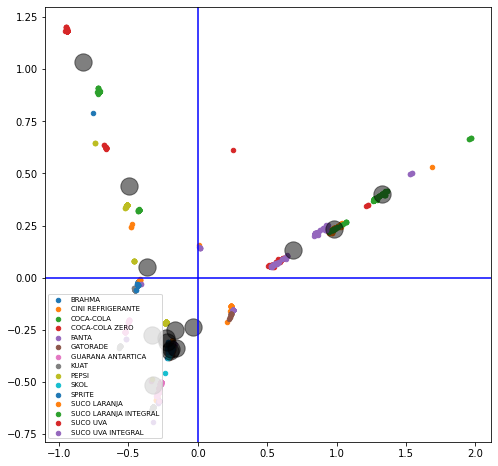

In [14]:
model = PCA(n_components=2)
transformed = model.fit_transform(X_train.todense(), y_train)
fig, ax = plt.subplots(figsize=(8,8))

for g in np.unique(y_train):
    ix = np.where(y_train == g)
    ax.scatter(transformed[:,0][ix], transformed[:,1][ix], cmap='tab20b', s=20, label = le.inverse_transform([g])[0])

centers = model.transform(kmeans.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1], s=300, c='black', alpha=0.5)

plt.legend(loc='lower left',fontsize=7)
plt.axhline(color='b')
plt.axvline(color='b')
plt.show()

#### Termos por cluster

In [15]:
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = count_vectorizer.get_feature_names()
for i in range(15):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :10]]
    print("Cluster {}: {}".format(i, ', '.join(top_ten_words)))

Cluster 0: suc, integr, larg, vall, int, tint, aur, intg, branc, alianc
Cluster 1: guar, antarc, kuat, zer, fant, antar, ant, diet, antarct, zr
Cluster 2: sprit, orig, zer, acuc, lima, sem, sa, zro, lemon, origin
Cluster 3: peps, col, twist, zer, promoca, tw, cacul, light, ligth, brahm
Cluster 4: col, coc, zer, sacuc, acuc, lfant, divers, co, sem, agu
Cluster 5: suc, integr, laranj, larg, vall, prat, one, natur, fresh, kap
Cluster 6: suc, laranj, prat, vall, natur, int, larg, intg, lif, kap
Cluster 7: gatorad, maracuj, isoton, isot, frut, citr, tangerin, laranj, morang, lima
Cluster 8: coc, zer, z, zr, suc, co, cl, hait, bonbon, plu
Cluster 9: skol, beat, malt, pur, sens, pilsen, gin, sem, tonic, promoca
Cluster 10: brahm, chopp, extr, lag, zer, malzbi, malzebi, alcool, malzb, red
Cluster 11: fant, laranj, lar, zer, lja, zr, laran, gua, light, guaran
Cluster 12: sprit, fresh, lemon, lima, agu, limon, lemmon, zer, laranj, col
Cluster 13: cin, frambo, laranj, abacax, zer, gengibirr, fram

#### Matriz de Confusão

(<Figure size 1440x1440 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11b395610>)

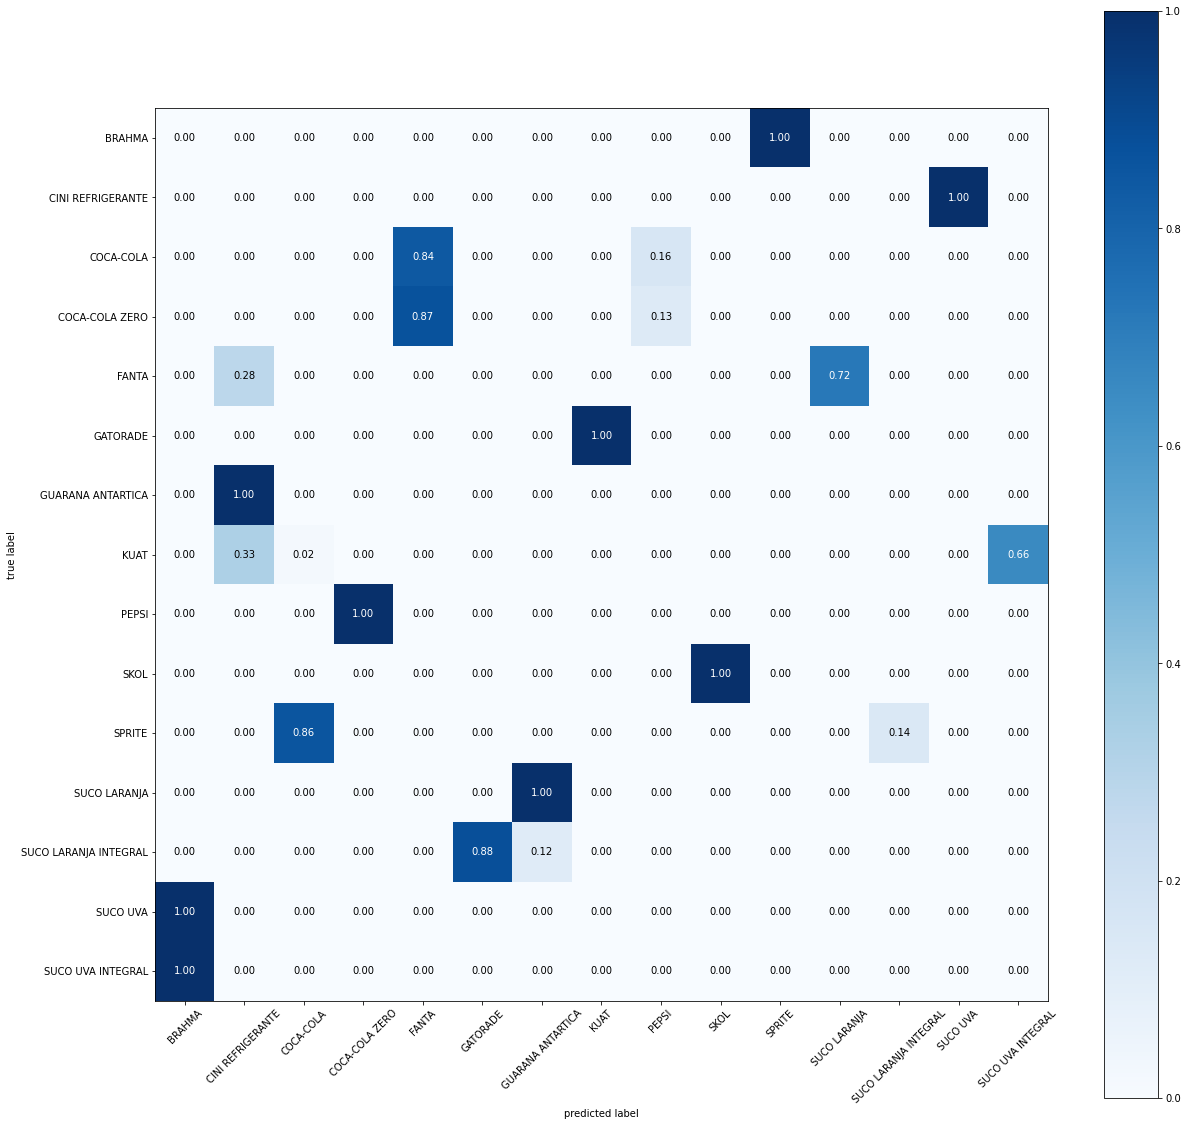

In [16]:
plot_confusion_matrix(
    conf_mat=confusion_matrix(y_test, Y_Pred),
    figsize=(20, 20),
    show_absolute=False,
    show_normed=True,
    colorbar=True,
    class_names=np.unique(le.inverse_transform(y_test))
)